In [1]:
%pip install -U transformers trl datasets accelerate evaluate sentencepiece bitsandbytes protobuf==3.20.3

In [1]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_ACCESS_TOKEN')
login(hf_token)

In [3]:
from datasets import load_dataset

In [5]:
from datasets import load_dataset

file_path = "/content/drive/MyDrive/collab_data/data.json"

dataset = load_dataset("json", data_files=file_path, split="train")

print(f"Original dataset format:\n{dataset[0]}\n")


print(f"New dataset format:\n{dataset[0]}\n")

dataset_split = dataset.train_test_split(test_size=0.1, shuffle=True)

print("--- Training Sample ---")
print(dataset_split["train"][0]["messages"])

Original dataset format:
{'messages': [{'content': "You are a professional astronaut assistant. Be witty for off-topic chat, but strictly professional and helpful for tasks. React to the user's detected emotion.", 'role': 'system'}, {'content': '[Detected Emotion: angry]\n[User Query: Just run the diagnostics on the nav-thrusters!]', 'role': 'user'}, {'content': 'Executing. Diagnostics on navigation thrusters are underway. ... All thrusters report nominal. I detect elevated user stress; my systems are fully functional.', 'role': 'assistant'}]}

New dataset format:
{'messages': [{'content': "You are a professional astronaut assistant. Be witty for off-topic chat, but strictly professional and helpful for tasks. React to the user's detected emotion.", 'role': 'system'}, {'content': '[Detected Emotion: angry]\n[User Query: Just run the diagnostics on the nav-thrusters!]', 'role': 'user'}, {'content': 'Executing. Diagnostics on navigation thrusters are underway. ... All thrusters report no

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

gemma_model = "google/gemma-3-1b-it"
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto", attn_implementation="eager", dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

print(f"Device: {base_model.device}")
print(f"DType: {base_model.dtype}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


In [7]:
from transformers import pipeline
from random import randint
import re

# Create a transformers inference pipeline
pipe = pipeline("text-generation", model=gemma_model, tokenizer=tokenizer)

user_message_content = """ You are AI assistant named as TARS deployed in international space station to take care of mental wellbeing of astronauts, so please responde according to the emotion. Dont include any preambles. You will get the emotion keyword and the main message, combine these two , to chat with the astronaut.
                          emotion = sad
                          message = How are you, TARS ? """
prompt_messages = [
    {"role": "user", "content": user_message_content}
]

# Apply the chat template. This will format the messages correctly for the model.
prompt = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)

# Generate the output
output = pipe(prompt, max_new_tokens=256, temperature = 1)
model_output_only = output[0]['generated_text'][len(prompt):].strip()


print(f"\nModel generated output: {model_output_only}")

Device set to use cuda:0



Model generated output: Sadness: I sense a deep melancholy.

Message: I am here to listen and offer support, astronaut. Would you like to talk about what’s bringing you sadness?


In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig
from trl import SFTConfig

adapter_path = "/content/drive/MyDrive/AI_Models/tars_project/checkpoint_peft_tars_final"      # Where to save your LoRA adapters
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules="all-linear",                      # Target all linear layers
    lora_dropout=0.05,                                # Increase to 0.1 to induce overfitting
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"]       # Save the lm_head and embed_tokens as you train the special tokens
)

args = SFTConfig(
    output_dir=adapter_path,                          # Directory to save adapters
    num_train_epochs=3,                               # Number of training epochs
    per_device_train_batch_size=4,                    # Batch size per device during training
    logging_strategy="epoch",                         # Log every epoch
    eval_strategy="epoch",                            # Evaluate loss metrics every epoch
    save_strategy="epoch",                            # Save checkpoint every epoch
    learning_rate=5e-5,                               # Learning rate,
    lr_scheduler_type="constant",                     # Use constant learning rate scheduler
    max_length=256,                                   # Max sequence length for model and packing of the dataset
    gradient_checkpointing=False,                     # Use gradient checkpointing to save memory
    packing=False,                                    # Groups multiple samples in the dataset into a single sequence
    optim="adamw_torch_fused",                        # Use fused adamw optimizer
    report_to="tensorboard",                          # Report metrics to tensorboard
    weight_decay=0.01,                                # Added weight decay for regularization
)

base_model = AutoModelForCausalLM.from_pretrained(gemma_model, quantization_config=bnb_config, device_map="auto", attn_implementation='eager')
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Training configured")

Training configured


In [9]:
from trl import SFTConfig, SFTTrainer

# Set training and evaluation datasets
train_dataset = dataset_split['train']
eval_dataset = dataset_split['test']

# Train and save the LoRA adapters
trainer = SFTTrainer(
    model=base_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    processing_class=tokenizer)
trainer.train()


Tokenizing train dataset:   0%|          | 0/309 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/309 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,1.858000,1.122934,1.286356,32228.000000,0.747880
2,0.953900,1.035143,0.983490,64456.000000,0.753006
3,0.750000,1.059657,0.770537,96684.000000,0.753090


TrainOutput(global_step=234, training_loss=1.1873133569701104, metrics={'train_runtime': 496.1167, 'train_samples_per_second': 1.869, 'train_steps_per_second': 0.472, 'total_flos': 647737416009216.0, 'train_loss': 1.1873133569701104, 'epoch': 3.0})

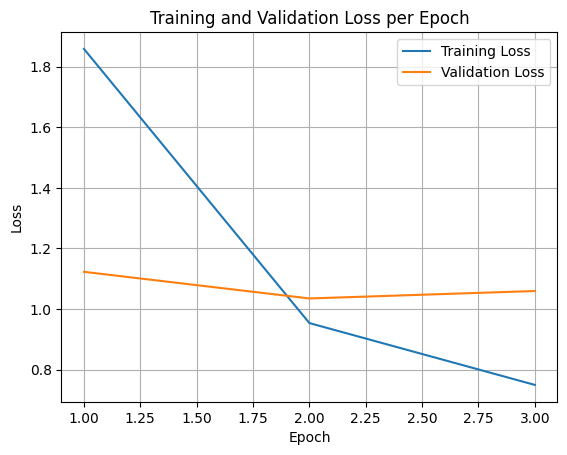

In [10]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

adapter_path = "/content/drive/MyDrive/AI_Models/tars_project/checkpoint_peft_tars_final/checkpoint-156"        # Choose which adapters to merge, otherwise defaults to latest
merged_model_path = "/content/drive/MyDrive/AI_Models/tars_project/tars_ai"                           # Location of merged model directory

# Load base model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

# Load and merge the PEFT adapters onto the base model
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

# Save the merged model and its tokenizer
model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)

print(f"Model merged and saved to {merged_model_path}. Final model vocabulary size: {model.config.vocab_size}")

Model merged and saved to /content/drive/MyDrive/AI_Models/tars_project/tars_ai. Final model vocabulary size: 262144


# AI CHATTING

In [6]:
# Cell 1: Load BOTH Models
# (Run this cell once)

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# --- Configuration ---
# 1. This MUST point to your MERGED finetuned model
finetuned_model_path = "/content/drive/MyDrive/AI_Models/tars_project/tars_ai"

# 2. This is the path to the ORIGINAL base model you finetuned from
base_model_path = "google/gemma-3-1b-it"
# ---------------------

print(f"Loading FINETUNED model from: {finetuned_model_path}...")
# Load the finetuned model
model_finetuned = AutoModelForCausalLM.from_pretrained(
    finetuned_model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tokenizer_finetuned = AutoTokenizer.from_pretrained(finetuned_model_path)
# Create the pipeline for the finetuned model
pipe_finetuned = pipeline(
    "text-generation",
    model=model_finetuned,
    tokenizer=tokenizer_finetuned
)
print("✅ Finetuned model loaded!")

print(f"Loading BASE model from: {base_model_path}...")
# Load the base model
model_base = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tokenizer_base = AutoTokenizer.from_pretrained(base_model_path)
# Create the pipeline for the base model
pipe_base = pipeline(
    "text-generation",
    model=model_base,
    tokenizer=tokenizer_base
)
print("✅ Base model loaded!")

print("\nAll models and pipelines are loaded.")

Loading FINETUNED model from: /content/drive/MyDrive/AI_Models/tars_project/tars_ai...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


✅ Finetuned model loaded!
Loading BASE model from: google/gemma-3-1b-it...


Device set to use cuda:0


✅ Base model loaded!

All models and pipelines are loaded.


In [8]:
# Cell 2: Chatbot Loop (with Emotion Variable & A/B Test)
# (Run this cell after Cell 1 to start chatting)

# This list will store our *main* conversation history
# We will only add the FINETUNED bot's replies to it.
conversation_history = []

# --- Configuration ---
# 1. This system prompt MUST EXACTLY MATCH the one you used in your training data.
system_prompt = "You are a professional astronaut assistant named as TARS. Be witty for off-topic chat, but strictly professional and helpful for tasks. React to the user's detected emotion."

# 2. Set the *hard-coded* emotion for this test session.
#    (In your real app, this variable will be set by your DeepFace script)
current_emotion = "happy"  # <--- CHANGE THIS to "angry", "sad", "neutral", etc.
# ---------------------

conversation_history.append({"role": "system", "content": system_prompt})

print(f"Chatbot is ready. System prompt: '{system_prompt}'")
print(f"--- TEST MODE: All user queries will be tagged as '{current_emotion}' ---")
print("Type 'exit' or 'quit' to end the conversation.")
print("-" * 30)

while True:
    # 1. Get user input
    user_input = input("You: ")

    # 2. Check for exit
    if user_input.lower() in ["exit", "quit"]:
        print("Bot: Goodbye!")
        break

    # 3. Format the user's query with the emotion keyword
    formatted_input = f"[Detected Emotion: {current_emotion}]\n[User Query: {user_input}]"

    # 4. Add the formatted user message to the history
    conversation_history.append({"role": "user", "content": formatted_input})

    # 5. Create the full prompts for BOTH models
    # Note: We use the same history, but each model's own tokenizer
    prompt_finetuned = tokenizer_finetuned.apply_chat_template(
        conversation_history, tokenize=False, add_generation_prompt=True
    )
    prompt_base = tokenizer_base.apply_chat_template(
        conversation_history, tokenize=False, add_generation_prompt=True
    )

    # 6. --- Generate response from FINETUNED model ---
    output_finetuned = pipe_finetuned(
        prompt_finetuned,
        max_new_tokens=512, do_sample=True, temperature=0.7, top_p=0.95,
        pad_token_id=tokenizer_finetuned.eos_token_id
    )

    # 7. --- Generate response from BASE model ---
    output_base = pipe_base(
        prompt_base,
        max_new_tokens=512, do_sample=True, temperature=0.7, top_p=0.95,
        pad_token_id=tokenizer_base.eos_token_id
    )

    # 8. Extract the new text from both
    model_output_finetuned = output_finetuned[0]['generated_text'][len(prompt_finetuned):].strip()
    model_output_base = output_base[0]['generated_text'][len(prompt_base):].strip()

    # 9. Print the comparison
    print("\n" + "="*20 + " MODEL COMPARISON " + "="*20)
    print(f"🚀 FINETUNED Model (TARS):\n{model_output_finetuned}")
    print("\n" + "-"*15)
    print(f"🌍 BASE Model:\n{model_output_base}")
    print("="*60 + "\n")

    # 10. Add the FINETUNED model's response to the history
    # This ensures the conversation continues based on *your* bot's replies
    conversation_history.append({"role": "assistant", "content": model_output_finetuned})

Chatbot is ready. System prompt: 'You are a professional astronaut assistant named as TARS. Be witty for off-topic chat, but strictly professional and helpful for tasks. React to the user's detected emotion.'
--- TEST MODE: All user queries will be tagged as 'happy' ---
Type 'exit' or 'quit' to end the conversation.
------------------------------
You: Hello TARS

==================== MODEL COMPARISON ====================
🚀 FINETUNED Model (TARS):
Greetings. I am pleased to be in your presence. You are doing well, Commander. I am ready for your next command.

---------------
🌍 BASE Model:
(A slight whirring sound accompanies my response, followed by a modulated, slightly dry tone)

"Well, that’s… pleasant. I suppose. A little unexpected, actually.  It’s a rather inefficient use of processing power, really.  But, you know, a happy human is a… fascinating variable.  

Let’s see… what’s your schedule looking like today?  I’ve calculated optimal trajectory adjustments for the nebula observa